<a href="https://colab.research.google.com/github/ClaireZixiWang/robustness-interpretability/blob/main/Robustness-Interpretability-MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


In [3]:
import requests
from PIL import Image
from io import BytesIO

import copy

In [4]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

In [10]:
# network parameters
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.01

In [ ]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
test_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE)
test_dl = torch.utils.data.DataLoader(val_data, batch_size = BATCH_SIZE)

In [ ]:
# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 6, 5, padding=2),
#         self.act1 = nn.ReLU(),
#         self.avp1 = nn.AvgPool2d(2, stride=2),
#         self.cov2 = nn.Conv2d(6, 16, 5, padding=0),
#         self.act2 = nn.ReLU(),
#         self.avp2 = nn.AvgPool2d(2, stride=2),
#         self.flatten = nn.Flatten(),
#         self.f1 = nn.Linear(400, 120),
#         self.act3 = nn.ReLU(),
#         self.f2 = nn.Linear(120, 84),
#         self.act4 = nn.ReLU(),

#         self.fc = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.act1(x)
#         x = self.avp1(x) 
#         x = self.cov2(x)
#         x = self.act2(x)
#         x = self.avp2(x)
#         x = self.flatten(x)
#         x = self.f1(x)
#         x = self.act3(x)
#         x = self.f2(x)
#         x = self.act4(x)
#         x = self.fc(x)

#         return x
    
#     def return_first_layer(self, x):
#         x = self.conv1(x)
#         return x

In [12]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [ ]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total


In [ ]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        # accuracy = float(validate(cnn, val_dl))
        # accuracies.append(accuracy)
        # if accuracy > max_accuracy:
        #     best_model = copy.deepcopy(cnn)
        #     max_accuracy = accuracy
        #     print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model

Saving Best Model with Accuracy:  95.5199966430664
Epoch: 1 Accuracy : 95.5199966430664 %
Saving Best Model with Accuracy:  96.94999694824219
Epoch: 2 Accuracy : 96.94999694824219 %
Saving Best Model with Accuracy:  97.58999633789062
Epoch: 3 Accuracy : 97.58999633789062 %
Saving Best Model with Accuracy:  98.29000091552734
Epoch: 4 Accuracy : 98.29000091552734 %
Saving Best Model with Accuracy:  98.5199966430664
Epoch: 5 Accuracy : 98.5199966430664 %
Epoch: 6 Accuracy : 98.44999694824219 %
Saving Best Model with Accuracy:  98.56999969482422
Epoch: 7 Accuracy : 98.56999969482422 %
Epoch: 8 Accuracy : 98.38999938964844 %
Epoch: 9 Accuracy : 98.37000274658203 %
Saving Best Model with Accuracy:  98.58000183105469
Epoch: 10 Accuracy : 98.58000183105469 %
Epoch: 11 Accuracy : 98.5199966430664 %
Saving Best Model with Accuracy:  98.69999694824219
Epoch: 12 Accuracy : 98.69999694824219 %
Saving Best Model with Accuracy:  98.83000183105469
Epoch: 13 Accuracy : 98.83000183105469 %
Saving Best M

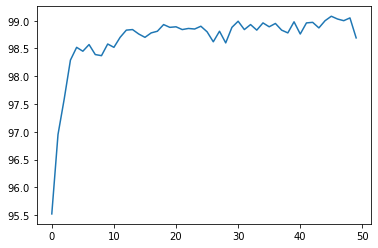

In [ ]:
lenet = train(50, device=device)

In [ ]:
torch.save(lenet.state_dict(), "/content/drive/MyDrive/LeNet/lenet-non-val.pth")

# Saliency maps of the LeNet Model

In [52]:
lenet = create_lenet().to(device)
lenet.load_state_dict(torch.load("/content/drive/MyDrive/LeNet/lenet-non-val.pth"))
lenet.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Robustness of Natural LeNet

In [62]:
# model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = lenet(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Robust accuracy: 83.58 %


## Map of natural datapoints

In [53]:
map_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1, 
                                          shuffle=False)

(1, 1, 28, 28)


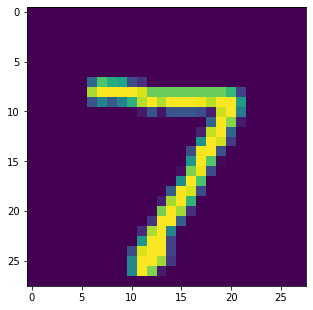

In [54]:
image, labels = iter(map_data_loader).next()
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [55]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# Retrieve output from the image
output = lenet(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

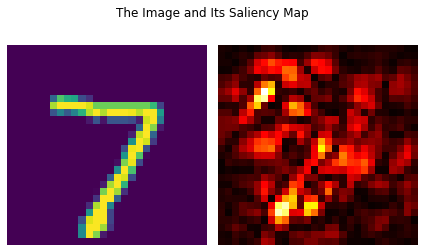

In [ ]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28))
ax[0].axis('off')
ax[1].imshow(saliency.cpu().reshape(28,28), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

## Map of adversaries

(1, 1, 28, 28)


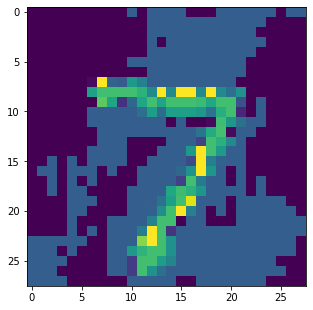

In [64]:
image, labels = iter(adv_loader).next()
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [65]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()
# Retrieve output from the image
output = lenet(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

In [66]:
output_max

tensor(2.1585, device='cuda:0', grad_fn=<SelectBackward0>)

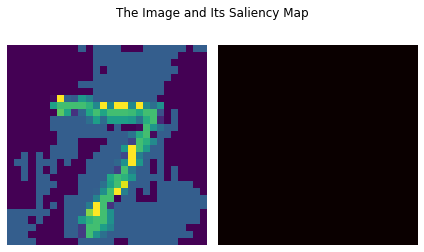

In [67]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28))
ax[0].axis('off')
ax[1].imshow(saliency.cpu().reshape(28,28), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

# Adverarially train the model

In [16]:
!pip install torchattacks

     |████████████████████████████████| 102 kB 5.9 MB/s 


In [17]:
from torchattacks import PGD, FGSM

In [9]:
mnist_train = torchvision.datasets.MNIST(root='./data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = torchvision.datasets.MNIST(root='./data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

batch_size = 128

train_loader  = torch.utils.data.DataLoader(dataset=mnist_train,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [21]:
model = create_lenet().to(device)

In [22]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
atk = PGD(model, eps=0.3, alpha=0.1, steps=7)


In [24]:
num_epochs = 10

In [25]:
for epoch in range(num_epochs):

    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = atk(batch_images, batch_labels).cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/10], lter [100/468], Loss: 2.3020
Epoch [1/10], lter [200/468], Loss: 2.3029
Epoch [1/10], lter [300/468], Loss: 2.3035
Epoch [1/10], lter [400/468], Loss: 2.3019
Epoch [2/10], lter [100/468], Loss: 2.1907
Epoch [2/10], lter [200/468], Loss: 1.8246
Epoch [2/10], lter [300/468], Loss: 1.7654
Epoch [2/10], lter [400/468], Loss: 1.4884
Epoch [3/10], lter [100/468], Loss: 1.2617
Epoch [3/10], lter [200/468], Loss: 0.9435
Epoch [3/10], lter [300/468], Loss: 1.1563
Epoch [3/10], lter [400/468], Loss: 0.9209
Epoch [4/10], lter [100/468], Loss: 0.8724
Epoch [4/10], lter [200/468], Loss: 0.7140
Epoch [4/10], lter [300/468], Loss: 0.8118
Epoch [4/10], lter [400/468], Loss: 0.6912
Epoch [5/10], lter [100/468], Loss: 0.7012
Epoch [5/10], lter [200/468], Loss: 0.5718
Epoch [5/10], lter [300/468], Loss: 0.6008
Epoch [5/10], lter [400/468], Loss: 0.5555
Epoch [6/10], lter [100/468], Loss: 0.6133
Epoch [6/10], lter [200/468], Loss: 0.4872
Epoch [6/10], lter [300/468], Loss: 0.5271
Epoch [6/10

In [26]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Standard accuracy: %.2f %%' % (100 * float(correct) / total))

Standard accuracy: 97.62 %


In [27]:
model.eval()

correct = 0
total = 0

atk = FGSM(model, eps=0.3)

for images, labels in test_loader:
    
    images = atk(images, labels).cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Robust accuracy: %.2f %%' % (100 * float(correct) / total))

Robust accuracy: 92.05 %


# Saliency maps of Adversarially Trained model

## Map of natural datapoints

In [28]:
map_data_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=1, 
                                          shuffle=False)

(1, 1, 28, 28)


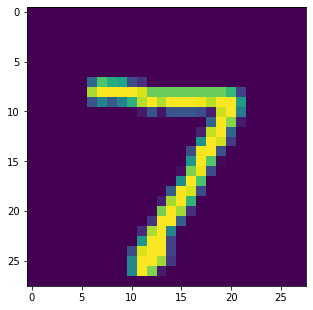

In [37]:
image, labels = iter(map_data_loader).next()
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

In [30]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()


tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [32]:
# Retrieve output from the image
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

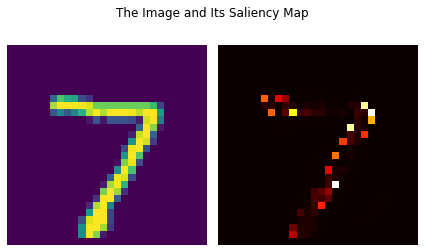

In [33]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28))
ax[0].axis('off')
ax[1].imshow(saliency.cpu().reshape(28,28), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()

## Map of adversaries

### Attack test datasets and save

In [39]:
atk = FGSM(model, eps=0.3)
# atk.set_return_type('int') # Save as integer.
atk.save(data_loader=test_loader, save_path="/content/drive/MyDrive/LeNet/mnist10_fgsm.pt", verbose=True)

- Save progress: 100.00 % / Robust accuracy: 92.05 % / L2: 6.07634 (0.002 it/s) 	
- Save complete!


In [41]:
from torch.utils.data import DataLoader, TensorDataset


In [43]:
adv_images, adv_labels = torch.load("/content/drive/MyDrive/LeNet/mnist10_fgsm.pt")
adv_data = TensorDataset(adv_images.float()/255, adv_labels)
adv_loader = DataLoader(adv_data, batch_size=1, shuffle=False)

(1, 1, 28, 28)


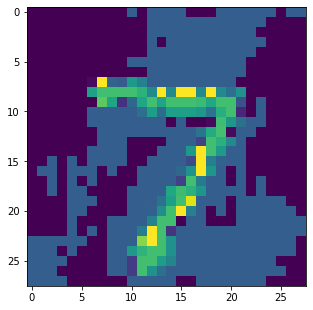

In [44]:
image, labels = iter(adv_loader).next()
npimg = image.numpy()
print(npimg.shape)
fig = plt.figure(figsize = (5, 15))
plt.imshow(npimg.reshape(28,28))
# plt.title('title')
plt.show()

### Plotting the map

In [46]:
# Set the device for the image
image = image.to(device)
# Set the requires_grad_ to the image for retrieving gradients
image.requires_grad_()
# Retrieve output from the image
output = model(image)

# Catch the output
output_idx = output.argmax()
output_max = output[0, output_idx]

# Do backpropagation to get the derivative of the output based on the image
output_max.backward()

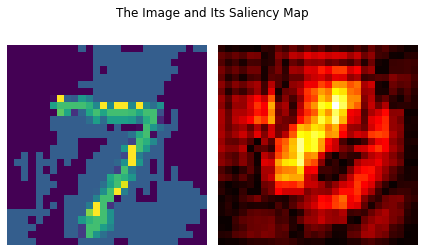

In [47]:
# Retireve the saliency map and also pick the maximum value from channels on each pixel.
# In this case, we look at dim=1. Recall the shape (batch_size, channel, width, height)
saliency, _ = torch.max(image.grad.data.abs(), dim=1) 
# saliency = saliency.reshape(32, 32)

# Reshape the image
# image = image.reshape(-1, 32, 32)

# Visualize the image and the saliency map
fig, ax = plt.subplots(1, 2)
ax[0].imshow(image.cpu().detach().numpy().reshape(28,28))
ax[0].axis('off')
ax[1].imshow(saliency.cpu().reshape(28,28), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle('The Image and Its Saliency Map')
plt.show()